In [283]:
from search_engine.search_engine import SearchEngine
import networkx as nx
from networkx import Graph
from sklearn.model_selection import train_test_split
import implicit
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import warnings
import csv
warnings.filterwarnings('ignore')

In [2]:
search_engine = SearchEngine()

What ranking mode do you want?
1. TF-IDF
2. WORD2VEC
1


In [3]:
search_engine.tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
created_at                 1000 non-null object
id_str                     1000 non-null object
text                       1000 non-null object
source                     1000 non-null object
truncated                  1000 non-null bool
in_reply_to_screen_name    170 non-null object
user                       1000 non-null object
reply_count                1000 non-null int64
retweet_count              1000 non-null int64
favorite_count             1000 non-null int64
entities                   1000 non-null object
favorited                  1000 non-null bool
retweeted                  1000 non-null bool
filter_level               1000 non-null object
timestamp_ms               1000 non-null object
retweeted_status           705 non-null object
extended_tweet             151 non-null object
extended_entities          42 non-null object
withheld_in_countries      1 non-null object

In [ ]:
#u -> search_engine.tweets.user[0]['screen_name']
#v -> search_engine.tweets.retweeted_status[1]['user']['screen_name']

In [4]:
#Para Poner bonito -> dictionario de los usuarios v
#Mirar página en favoritos
#Add weight edges from how many times user u retweeted user v
g = nx.Graph()
for tweet in search_engine.tweets.iterrows():
    if str(tweet[1]['retweeted_status'])!='nan':
        u=tweet[1]['user']['screen_name']
        v=tweet[1]['retweeted_status']['user']['screen_name']
        g.add_node(u)
        g.add_node(v)
        g.add_edge(u,v)

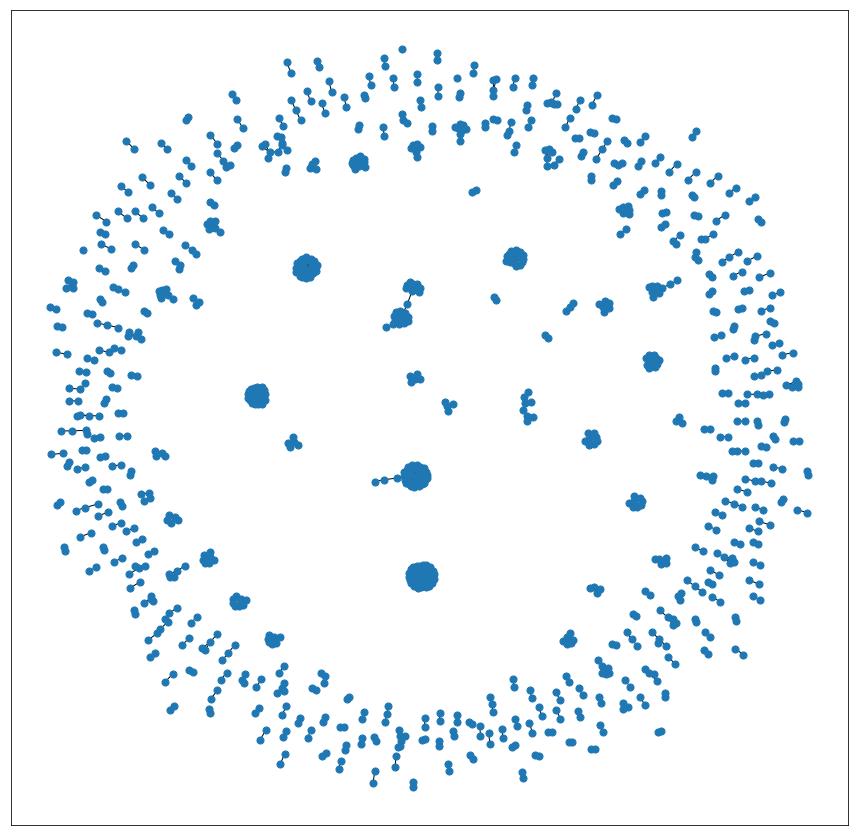

In [6]:
pos=nx.spring_layout(g)
plt.figure(figsize=(15,15))
nx.draw_networkx(g, pos, node_shape='o', node_size=50, with_labels=False, font_weight='bold')
plt.show()

In [7]:
#Recomender System
# -ASL -> No se que hacer con test

In [112]:
train, test = train_test_split(list(g.edges), test_size = .2 ,random_state = 1) #559 - 140

In [224]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in list(g.edges):
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

sparse_useru_userv = sparse.csr_matrix((data, indices, indptr), dtype=int)

In [225]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=200)

alpha_val = 40
data_conf = (sparse_useru_userv * alpha_val).astype('double')

model.fit(data_conf)

In [226]:
def similar_users(user_id: int, top: int, vocabulary:dict) -> list:
    ASL_similar_users=model.similar_users(user_id,top)
    ASL_similar_users_with_names=number_to_username(ASL_similar_users, vocabulary)
    return ASL_similar_users_with_names

def number_to_username(ASL_list: list, vocabulary: dict) -> list:
    ASL_list_transformed=[]
    for i in range(len(ASL_list)):
        name=list(vocabulary.keys())[list(vocabulary.values()).index(ASL_list[i][0])]
        new_tuple=(name, ASL_list[i][1])
        ASL_list_transformed.append(new_tuple)
    return ASL_list_transformed


In [227]:
#Poner como input
user_id=0
top_n_user_similars=10

ASL_sim_users=similar_users(user_id, top_n_user_similars, vocabulary)
ASL_sim_users

[('SuMoh7', 1.0000001),
 ('sageofthunder', 1.0),
 ('CBSNews', 1.0),
 ('Scotta98471548', 0.6343964),
 ('LotusOak2', 0.6343964),
 ('OnThisDayGaming', 0.55887806),
 ('ChouGokuOozaru', 0.558878),
 ('AnxiousKori_', 0.558878),
 ('DhaaGreekKing', 0.558878),
 ('_Chibi_Chu', 0.558878)]

In [238]:
#Adamic-Adar

In [261]:
def get_neighbors(username: str, usersu: list, usersv: list) -> list:
    neighbors=[]
    for i in range(len(usersu)):
        if (username==usersu[i]):
            neighbors.append(usersv[i])
        if (username==usersv[i]):
            neighbors.append(usersu[i])
    return neighbors

In [285]:
users_u=[names[0] for names in list(g.edges)]
users_v=[names[1] for names in list(g.edges)]

users_unique_list=set(users_u)|set(users_v)
adamic_avar_data=pd.DataFrame(columns=users_unique_list, index=users_unique_list)

#Maybe take off the pass and use user_x!=user_y:
for user_x in users_unique_list:
    for user_y in users_unique_list:
        if user_x==user_y:
            pass
        else:
            x_neighbors=set(get_neighbors(user_x, users_u, users_v))
            y_neighbors=set(get_neighbors(user_y, users_u, users_v))
        same_neighbors=x_neighbors&y_neighbors
        aa_val=0
        for n in same_neighbors:
            num_neighbors=len(get_neighbors(n, users_u, users_v))
            aa_val+=(1/math.log(num_neighbors))
        adamic_avar_data[user_x][user_y]=aa_val
        adamic_avar_data[user_y][user_x]=aa_val

In [298]:
#pd.set_option('display.max_rows', adamic_avar_data.shape[0]+1)
adamic_avar_data

,1Krohmer13,jdf754,DoYouEvenLif,rickcoss1,HeyRaina_C,Subytweets,mlewis123,RealSLokhova,travisakers,_bestdej,...,carolynryan,gex_daniel,RydeorDye_,BiekerAnnie,lucy_bconner,xuxiviews,currie14_kelly,CharismaAlasta1,SchmittNYC,DorrowMichelle
1Krohmer13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jdf754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DoYouEvenLif,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rickcoss1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HeyRaina_C,0,0,0,0,0,0,0,0,0,0.333808,...,0,0,0,0,0,0,0,0,0,0
Subytweets,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlewis123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RealSLokhova,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
travisakers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_bestdej,0,0,0,0,0.333808,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
